In [20]:
# Import our libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, make_scorer
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [21]:
# Load in our X (processed_fights.csv) and y (processed_data_labels.csv)
X = pd.read_csv('processed_fights.csv')
y = pd.read_csv('processed_data_labels.csv')

In [22]:
# Create our train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('Training set shape:', X_train.shape, y_train.shape)
print('Testing set shape:', X_test.shape, y_test.shape)
print('Number of 0s in test =', (y_test == 0).sum().sum())
print('Number of 1s in test =', (y_test == 1).sum().sum())

Training set shape: (4164, 33) (4164, 1)
Testing set shape: (1042, 33) (1042, 1)
Number of 0s in test = 515
Number of 1s in test = 527


In [23]:
# Standardize non-categorical features
features_to_scale = ['f1_reach', 'f1_sapm', 'f1_slpm',
       'f1_stk_acc', 'f1_stk_def', 'f1_sub_avg', 'f1_td_acc', 'f1_td_avg',
       'f1_td_def', 'f1_weight', 'f2_reach', 'f2_sapm', 'f2_slpm',
       'f2_stk_acc', 'f2_stk_def', 'f2_sub_avg', 'f2_td_acc', 'f2_td_avg',
       'f2_td_def', 'f2_weight', 'f1_wins', 'f1_losses', 'f1_draws', 'f2_wins',
       'f2_losses', 'f2_draws', 'f1_age', 'f2_age', 'f1_height', 'f2_height']

scaler = StandardScaler()
X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

# Save our scaler for later reference
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Accuracy: 0.789827255278311


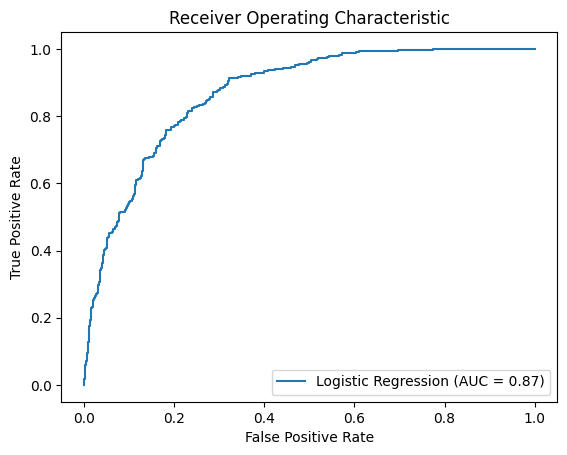

In [27]:
# Train a logistic regression model
lr = LogisticRegressionCV(penalty='l1', solver='liblinear', random_state=42)
lr.fit(X_train, y_train)

# Determine our logistic regression model accuracy and AUC
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
print('Accuracy:', accuracy)
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc)
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [18]:
# Train on multiple models
classifiers = [
    LogisticRegressionCV(random_state=42),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
]

classifiers_names = [
    'Logistic Regression',
    'K Neighbors',
    'Decision Tree Classifier',
    'RandomForest Classifier',
    'GradientBoostingClassifier',
    'AdaBoostClassifier'
]

for index, clf in enumerate(classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    print(classifiers_names[index])
    print('Accuracy:', accuracy)
    print('AUC: %0.2f' % roc_auc)
    print()

    with open('{}.pkl'.format(classifiers_names[index]), 'wb') as f:
        pickle.dump(clf, f)


Logistic Regression
Accuracy: 0.8080614203454894
AUC: 0.89

K Neighbors
Accuracy: 0.8051823416506718
AUC: 0.87

Decision Tree Classifier
Accuracy: 0.7495201535508638
AUC: 0.75

RandomForest Classifier
Accuracy: 0.8685220729366603
AUC: 0.93

GradientBoostingClassifier
Accuracy: 0.845489443378119
AUC: 0.92

AdaBoostClassifier
Accuracy: 0.8157389635316699
AUC: 0.90



Accuracy: 0.8320537428023033


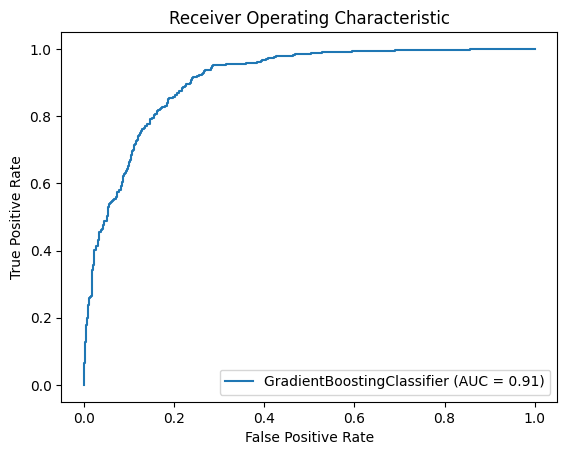

In [11]:
# Train a GradientBoosting classifier model
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

# Determine our gbc model accuracy and AUC
y_pred = gbc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, gbc.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
print('Accuracy:', accuracy)
plt.plot(fpr, tpr, label='GradientBoostingClassifier (AUC = %0.2f)' % roc_auc)
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
""" Now let us do some GridSearchCV for GradientBoostingClassifier. """

# Define the Gradient Boosting Classifier model
gbc_gs = GradientBoostingClassifier(random_state=42)

# Define the parameter grid to search
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4]
}

# Define the evaluation metric
scorer = make_scorer(accuracy_score)

# Perform grid search with cross-validation
grid_search = GridSearchCV(gbc_gs, param_grid, scoring=scorer, cv=5, verbose=1)
grid_search.fit(X, y)

# Print the best parameters and the corresponding accuracy score
print("Best parameters: ", grid_search.best_params_)
print("Best Model: ", grid_search.best_estimator_)

Accuracy: 0.8704414587332053


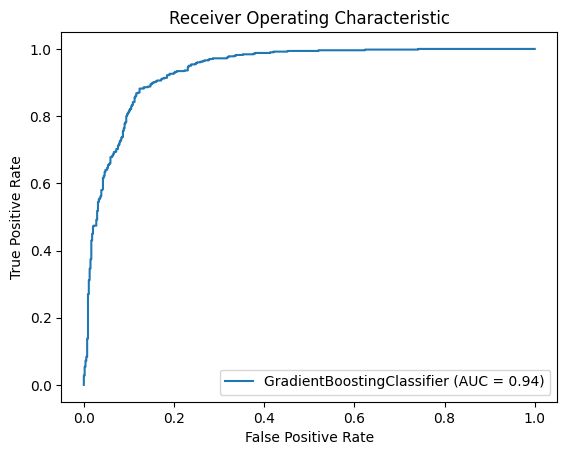

In [19]:
# Train a GradientBoosting classifier model
gbc = GradientBoostingClassifier(random_state=42, learning_rate=0.2, max_depth=4, n_estimators=200)
gbc.fit(X_train, y_train)

# Determine our gbc model accuracy and AUC
y_pred = gbc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, gbc.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
print('Accuracy:', accuracy)
plt.plot(fpr, tpr, label='GradientBoostingClassifier (AUC = %0.2f)' % roc_auc)
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

with open('gbc_gs.pkl', 'wb') as f:
    pickle.dump(gbc, f)

In [ ]:
weight_class = input("Enter weight class: ")
f1_reach = input("Enter fighter 1's reach: ")
f1_sapm = input("Enter fighter 1's SApM: ")
f1_slpm = input("Enter fighter 1's SLpM: ")
f1_stance = input("Enter fighter 1's stance: ")
f1_stk_acc = input("Enter fighter 1's stk_acc: ")
f1_stk_def = input("Enter fighter 1's stk_def: ")
f1_sub_avg = input("Enter fighter 1's sub_avg: ")
f1_td_acc = input("Enter fighter 1's td_acc: ")
f1_td_avg = input("Enter fighter 1's td_avg: ")
f1_td_def = input("Enter fighter 1's td_def: ")
f1_weight = input("Enter fighter 1's weight: ")
f2_reach = input("Enter fighter 2's reach: ")
f2_sapm = input("Enter fighter 2's SApM: ")
f2_slpm = input("Enter fighter 2's SLpM: ")
f2_stance = input("Enter fighter 2's stance: ")
f2_stk_acc = input("Enter fighter 2's stk_acc: ")
f2_stk_def = input("Enter fighter 2's stk_def: ")
f2_sub_avg = input("Enter fighter 2's sub_avg: ")
f2_td_acc = input("Enter fighter 2's td_acc: ")
f2_td_avg = input("Enter fighter 2's td_avg: ")
f2_td_def = input("Enter fighter 2's td_def: ")
f2_weight = input("Enter fighter 2's weight: ")
f1_wins = input("Enter fighter 1's wins: ")
f1_losses = input("Enter fighter 1's losses: ")
f1_draws = input("Enter fighter 1's draws: ")
f2_wins = input("Enter fighter 2's wins: ")
f2_losses = input("Enter fighter 2's losses: ")
f2_draws = input("Enter fighter 2's draws: ")
f1_age = input("Enter fighter 1's age: ")
f2_age = input("Enter fighter 2's age: ")
f1_height = input("Enter fighter 1's height: ")
f2_height = input("Enter fighter 2's height: ")


In [ ]:
features_names = [
    'weight_class', 'f1_reach', 'f1_sapm', 'f1_slpm', 'f1_stance',
    'f1_stk_acc', 'f1_stk_def', 'f1_sub_avg', 'f1_td_acc', 'f1_td_avg',
    'f1_td_def', 'f1_weight', 'f2_reach', 'f2_sapm', 'f2_slpm', 'f2_stance',
    'f2_stk_acc', 'f2_stk_def', 'f2_sub_avg', 'f2_td_acc', 'f2_td_avg',
    'f2_td_def', 'f2_weight', 'f1_wins', 'f1_losses', 'f1_draws', 'f2_wins',
    'f2_losses', 'f2_draws', 'f1_age', 'f2_age', 'f1_height', 'f2_height'
]

features = [
    [weight_class], [f1_reach], [f1_sapm], [f1_slpm], [2],
    [f1_stk_acc], [f1_stk_def], [f1_sub_avg], [f1_td_acc], [f1_td_avg],
    [f1_td_def], [f1_weight], [f2_reach], [f2_sapm], [f2_slpm], [f2_stance],
    [f2_stk_acc], [f2_stk_def], [f2_sub_avg], [f2_td_acc], [f2_td_avg],
    [f2_td_def], [f2_weight], [f1_wins], [f1_losses], [f1_draws], [f2_wins],
    [f2_losses], [f2_draws], [f1_age], [f2_age], [f1_height], [f2_height]
]

features_dict = dict(zip(features_names, features))
submitted_df = pd.DataFrame(features_dict)
print(submitted_df.info())

In [ ]:
features_to_scale = ['f1_reach', 'f1_sapm', 'f1_slpm',
       'f1_stk_acc', 'f1_stk_def', 'f1_sub_avg', 'f1_td_acc', 'f1_td_avg',
       'f1_td_def', 'f1_weight', 'f2_reach', 'f2_sapm', 'f2_slpm',
       'f2_stk_acc', 'f2_stk_def', 'f2_sub_avg', 'f2_td_acc', 'f2_td_avg',
       'f2_td_def', 'f2_weight', 'f1_wins', 'f1_losses', 'f1_draws', 'f2_wins',
       'f2_losses', 'f2_draws', 'f1_age', 'f2_age', 'f1_height', 'f2_height']

print(submitted_df.iloc[0])
submitted_df[features_to_scale] = scaler.transform(submitted_df[features_to_scale])

In [ ]:
prediction = gbc.predict(submitted_df)
prediction_probability = gbc.predict_proba(submitted_df)
print("The model predicts that fighter", int(prediction+1), "wins")
print("Confidence for that prediction is", float(prediction_probability[0][prediction]))